# Hydrometer

In [16]:
####
## Load libs
#

%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
#from sklearn import model_selection
#from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import scipy as scp
from scipy.stats import genextreme as gev
from scipy import interpolate as interp
import traceback
import json
import io
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
pd.options.mode.use_inf_as_na = True

## Functions definitions

In [2]:
####
## Definicoes para Interpolação
#

def initialization_interpolation(hydrometer_ts):
  '''
  Return interpolated dict time-series and the auxiliary dictionaries,
  x axis points to generate interpolated points (xinterp), x axis points to fit spline(x_ts), interpolated time series points (itp).
  '''
  pop(hydrometer_ts, thresh = 10)
  #print('hydro ', hydrometer_ts)
  xinterp = {k:np.array([i for i in range( np.size(hydrometer_ts[k]) ) if np.array(hydrometer_ts[k])[i] == 0.0  ]) for k in np.array(hydrometer_ts.keys())}
  pop(xinterp, thresh = 2)
  #print('interpolacao ', xinterp)
  x_ts = { k : np.setxor1d(np.linspace(0,np.size(hydrometer_ts[k])-1,np.size(hydrometer_ts[k]) ),xinterp[k]) for k in np.array(xinterp.keys())}  
  pop(x_ts, thresh = 4)
  #print('x_ts ', x_ts)

  itp_ts = {k:fit_spline(xinterp[k],x_ts[k],hydrometer_ts[k][x_ts[k].astype(np.int16)]) for k in np.array(x_ts.keys())}
  interpolated_ts = {k:interpolation(xinterp[k],itp_ts[k],hydrometer_ts[k].copy()) for k in np.array(x_ts.keys())}
  
  return interpolated_ts,itp_ts,xinterp,x_ts


def interpolation(xinterp,interp,hydrometer_ts):
   
  l = np.size(hydrometer_ts)

  # Energia 
  e = np.zeros(np.size(hydrometer_ts)-1)
  for i in range(0,np.size(hydrometer_ts)-1):
    e[i] = np.abs(hydrometer_ts[i+1] - hydrometer_ts[i])
  e_m = np.mean(e)
  e_std = e.std() + 1e-7
  i = 0 
  for x in xinterp:
    if x == 0 or x == (l-1):
      
      
      if np.abs(interp[i]) < 0.5:
        hydrometer_ts[x] = interp[i]
      else:
        if x == 0:
          hydrometer_ts[x] = hydrometer_ts[x+1]/3.0
        else:
          hydrometer_ts[x] = hydrometer_ts[x-1]/3.0
    else:        
        
        j = 1
        k = 1
        
        while ((hydrometer_ts[x-j] == 0.0) or (hydrometer_ts[x+k] == 0.0)) and (((x-j) > 0) and ((x+k) < (l-1)) ):
          j += 1
          while (hydrometer_ts[x+k] == 0.0) and ((x+k) < (l-1)):
            k += 1
          media = (hydrometer_ts[x-j]+hydrometer_ts[x+k]+1e-7)/2.0
          eps = ((np.abs(interp[i] - hydrometer_ts[x-j]) + np.abs( - interp[i] + hydrometer_ts[x+k]))/2.0 - e_m)/e_std
          if  np.abs(eps) > 2.0:            
            hydrometer_ts[x] = media
          else:
            hydrometer_ts[x] = interp[i]
        media = (hydrometer_ts[x-j]+hydrometer_ts[x+k]+1e-7)/2.0
    i += 1
  return hydrometer_ts


def fit_spline(x,x_points,y_points):

    #print('x and y ',len(x_points),len(y_points))
    #print('x eval ',x)

    
    
    tck = interp.splrep(x_points, y_points)
    #print('tck ',tck)
    return interp.splev(x, tck)

####
## Standardization and Log differentiation (exclusion of possible non-stationarity between time series samples)
#

def normalize_dict(d,std=False, log_diff=False, demean = False):
  for k,v in d.items():
    if log_diff:
      d[k] = np.array([ np.log(v[i+1]+1e-7) - np.log(v[i]+1e-7) for i in range(np.size(v)-1)])      
    if std == True:
      d[k] = (v - v.mean())/(v.std()+1e-6)
    if demean:
      d[k] = v - v.mean()    
    
def pop(hydrometer_ts, thresh = 40):
  '''
  Receive dict or list of time-series and pop the one who has less than thresh elements
  '''
  count_out = 0;
  if type(hydrometer_ts) == type([]):
    l = len(hydrometer_ts)
    i = 0
    while i < l:
      
      nsize = np.size(hydrometer_ts[i])
  
      if nsize > 1 and nsize < thresh:    
        
        hydrometer_ts.pop(i)
        count_out += 1
        l = len(hydrometer_ts)  
      elif nsize == 1:
        hydrometer_ts.pop(i)
        l = len(hydrometer_ts)
        count_out += 1
      else:        
        i += 1
    print('numero de registros restantes: ',len(hydrometer_ts))
      

  else:
    for k in hydrometer_ts.keys():
      nsize = np.size(hydrometer_ts[k])
      
      if nsize > 1:    
        if nsize < thresh:          
          hydrometer_ts.pop(k)
          count_out += 1          
      else:        
        hydrometer_ts.pop(k)  
        count_out += 1
    print('numero de registros restantes: ',len(hydrometer_ts.keys()))  
  print('numero de registros retirados: ',count_out)
  
####
## NaN number filtering and imputation  of 0.0s or what-ever function of dataframe/np.array you want
#   
    
def isnan(m, fillna = True, fillwith = lambda x: 0.0, verbose = True):
  '''
  Detect NaN and fill with provided fillwith function, standard is 0.0
  Input: np.array or DataFrame
  
  '''  
  if type(m) == type(np.array([])):
    for i in range(len(m[:,0])):
      for j in range(len(m[0,:])):
        if np.isnan(m[i,j]) == True:
          if verbose:
            print("{}".format((i,j)),m[i,j])
          if fillna:
            m[i,j] = fillwith(m)
  elif type(m) == type(pd.DataFrame([])):
    for k in np.array(m.index.unique()):
      v = np.array(m.loc[k,'volume_lido'])
      if len(v.shape) == 0:
        v = np.array([v])
      if np.isnan(v).any() == True:        
        for j in range(v.size):          
          if np.isnan(v[j]) == True:
            if verbose:
              print("{}".format((k,j)),v[j])
            if fillna and len(v.shape) == 1:
              m.loc[k,'volume_lido'] = fillwith(m)
            elif fillna:
              m.loc[k,'volume_lido'][j] = fillwith(m)
  print('-')

####
## Transform list or dict into matrix by thresholding the time-series by thresh.
#

def to_tensor(hydrometer_ts, thresh = 45): 
  '''
  Turn a list or dictionary of time series into a matrix by discarding the elements above thresh and excluding time series with less elemets than thresh.
  '''
  m = None
  pop(hydrometer_ts, thresh = thresh)
  # list-> np.array 2D
  if type(hydrometer_ts) == type([]):
    m = np.array([hydrometer_ts[i][0:thresh] for i in range(len(hydrometer_ts))])
    nomes = np.linspace(0,np.size(hydrometer_ts)-1,np.size(hydrometer_ts))
  # dict-> np.array 2D    
  if type(hydrometer_ts) == type({'':0.0}):
    m = np.array([hydrometer_ts[k][0:thresh] for k in hydrometer_ts.keys()])    
    nomes = hydrometer_ts.keys()
    
  return m,nomes

####
## Subtrair sazonalidade, não está muito funcional, talvez melhor com fourier.
#


def subtrai_sazonalidade(hydrometer_ts, medianizar = 15):
  '''
  Recebe dicionario de series temporais, e retorna lista de séries diferenciadas em relaçao a maior pico de autocorrelação
  TODO: testar graficamente. Setando temporariamente para 12.
  '''
  ac,n = acf(hydrometer_ts,medianizar)

  for j in range(len(n)):
    season = 0
    for i in range(1,len(ac[j])-medianizar):      
      count = 0
      argma = np.argmax(ac[j][count:count+medianizar])
      argmi = np.argmin(ac[j][count:count+medianizar])
      while count < len(ac[j])-1 and argmi > argma:
        if argma > argmi:       
          season = argma + count
          break;
        else:
          count += 1        
        argma = np.argmax(ac[j][count:count+medianizar])
        argmi = np.argmin(ac[j][count:count+medianizar])
        
        z = 1
        while z < count:
          argma = np.argmax(ac[j][count-z:count+medianizar])
          argmi = np.argmin(ac[j][count-z:count+medianizar])          
          if argma > argmi:       
            season = argma + count - z
            break
          else:
            z += 1                       
        
        
    #print('Season',season)    
    ts = [np.array(hydrometer_ts[i].copy()) for i in hydrometer_ts.keys()]
    for i in range(len(ts[j])-season):
      #ts[j][i] = ts[j][i]-ts[j][np.mod(i+season,np.size(ts[j][:]))]
      ts[j][i] = ts[j][i]-ts[j][np.mod(i+12,np.size(ts[j][:]))]
  
  return ts

def acf(hydrometer_ts,medianizar):
  '''
  Return list of autocorrelation function from dict of time-series and an array of size n of the acf.
  '''
  autocorr = lambda ts: scp.correlate(ts,ts, mode="full")/(scp.var(ts, ddof = 1)+1e-6)
  pop(hydrometer_ts, thresh = 2)
  ts = [np.array(hydrometer_ts[i].copy()) for i in hydrometer_ts.keys()]
  
  n = np.array([ int(np.size(scp.correlate(i,i, mode="full"))/2.0) for i in ts])
  acf = [ np.array([ np.mean(autocorr(ts[j])[i:i+medianizar]) for i in range(n[j],2*n[j]-medianizar) ] ) for j in range(len(n))]
  return acf,n

####
## Kernel Density Estimation
#

def getKernelDensityEstimation(values, x, bandwidth = 0.2, kernel = 'gaussian'):
    model = KernelDensity(kernel = kernel, bandwidth=bandwidth)
    model.fit(values[:, np.newaxis])
    log_density = model.score_samples(x[:, np.newaxis])
    return np.exp(log_density)

####
## Mutual Information Measures
#

def mutual_information(X,Y,k=5,base=np.exp(1)):
  '''
  pyMIestimator is a function for estimating Mutual Information

  Inputs function:
  X,Y         : an N x M matrix (samples x features)
  k           : the number of nearest neighbour
  unit base   : base=2 -> Shannon (bits), base=exp(1)=nat
 
  Outputs function:
  I1, I2      : mutual information estimates
 
  Martha Arbayani Zaidan, PhD
  Postdoctoral Research Fellow
  Aalto University, Finland
 
  References:
 
     Alexander Kraskov Harald Stogbauer, and Peter Grassberger,
     Estimating mutual information,
     Physical review E 69, no. 6 (2004): 066138.
 
     Jorge Numata, Oliver Ebenhoh and Ernst-Walter Knapp,
     Measuring correlations in metabolomic networks with mutual information,
     Genome Informatics 20 (2008): 112-122.
  '''
  [N,M] = X.shape #  The number of samples

  # Calculate the distance between each data point (sample)
  # and its k-th nearest neighbour:
  dx = np.zeros((N,N))
  dy = np.zeros((N,N))
  dz = np.zeros((N,N))

  for i in range(0,N):
    for j in range(0,N):
      dx[i,j] = np.sqrt(np.sum((X[i,:] - X[j,:])**2))
      dy[i,j] = np.sqrt(sum((Y[i,:] - Y[j,:])**2))
      dz[i,j] = max([dx[i,j], dy[i,j]])


  # Count nx(i) and ny(i) using the criteria defined in Kraskov et al. (2004)
  Eps = np.zeros((N,1))
  nx1 = np.zeros((N,1))
  ny1 = np.zeros((N,1))
  nx2 = np.zeros((N,1))
  ny2 = np.zeros((N,1))

  for i in range(0,N):

  # the first cols of {dx,dy,dz} are zeros because the first cols are
  # the distance between themselves, so we remove them here:
    dxS = dx[i,:]
    dxS[i] = np.nan
    idx=np.logical_not(np.isnan(dxS))
    dxS=dxS[idx]

    dyS = dy[i,:]
    dyS[i] = np.nan
    idx=np.logical_not(np.isnan(dyS))
    dyS=dyS[idx]

    dzS = dz[i,:]
    dzS[i] = np.nan
    idx=np.logical_not(np.isnan(dzS))
    dzS=dzS[idx]

    dzSort = np.sort(dzS)
  # Eps(i) is epsilon(i)/2
  # Eps(i) is the distance from sample z(i) to its k-th neighbor
    Eps[i] = dzSort[k-1]

  # For algorithm 1:
  # count the number nx(i) of points x(j) whose distance from x(i) is
  # strictly less than Eps, and similarly for y instead of x:
    nx1[i] = sum(dxS < Eps[i])
    ny1[i] = sum(dyS < Eps[i])

  # For algorithm 2:
  # we replace nx(i) and ny(i) by the number of points with
  # ||x(i)-x(j)|| <= Eps(i) and ||y(i)-y(j)|| <= Eps(i)
    nx2[i] = sum(dxS <= Eps[i])
    ny2[i] = sum(dyS <= Eps[i])

  # Estimating Mutual Information:
  I1 = (digamma(k) - (sum(digamma(nx1 + 1) + digamma(ny1 + 1)) / N) + digamma(N) ) / np.log(base)
  I2 = (digamma(k) - 1.0/k - (sum(digamma(nx2) + digamma(ny2)) / N) + digamma(N) ) / np.log(base)

  I1=np.sign(I1)*np.sqrt(1-np.exp(-2*abs(I1)))
  I2=np.sign(I2)*np.sqrt(1-np.exp(-2*abs(I2)))

  # No negative MI:
  if I1 < 0: I1 = 0
  elif I2 < 0: I2 = 0

  return I1, I2

def digamma ( x ):
  '''
   digamma function calculates digamma(x) = d(log(gamma(x)))/dX
   Authors:

    Original FORTRAN77 version by Jose Bernardo.
    Original Python version by John Burkardt.
    Modified Python version by Martha Arbayani Zaidan.
    This modified version takes numpy array input.

   Reference:

    Jose Bernardo,
    Algorithm AS 103:
    Psi ( Digamma ) Function,
    Applied Statistics,
    Volume 25, Number 3, 1976, pages 315-317.
  '''
  x=np.float64(x) # convert to be double precision

  #  Check the input.
  if ( x.any <= 0.0 ):
    value = 0.0
    return value

  #  Initialize.
  value = 0.0

  #  Use approximation for small argument.

  if ( x.any <= 0.000001 ):
    # Euler-Mascheroni constant:
    euler_mascheroni = 0.57721566490153286060651209008240243104215933593992
    value = - euler_mascheroni - 1.0 / x + 1.6449340668482264365 * x
    return value

  #  Reduce to DIGAMA(X + N).

  while ( x.any < 8.5 ):
    value = value - 1.0 / x
    x = x + 1.0

#  Use Stirling's (actually de Moivre's) expansion.

  r = 1.0 / x
  value = value + np.log ( x ) - 0.5 * r
  r = r * r
  value = value \
    - r * ( 1.0 / 12.0
    - r * ( 1.0 / 120.0
    - r * ( 1.0 / 252.0
    - r * ( 1.0 / 240.0
    - r * ( 1.0 / 132.0 ) ) ) ) )

  return value

####
##Plotting
#

def grid_plot(hydrometer_ts, shape, hidronum = 10):
  '''
  Dict/List grid-plot
  '''
  
  fig, axs = plt.subplots(shape[0], shape[1], sharex=True, sharey=False)    

  for i in np.arange(hidronum,hidronum+shape[0]):
    for j in np.arange(hidronum+shape[0],hidronum+shape[0]+shape[1]):
      if type(hydrometer_ts) == type({'':0.0}):        
        axs[i-hidronum][j-(hidronum+shape[0])].plot(hydrometer_ts[hydrometer_ts.keys()[i+j]], '-')
        axs[i-hidronum][j-(hidronum+shape[0])].set_title('{}'.format(hydrometer_ts.keys()[i+j]))
      else:
        axs[i-hidronum][j-(hidronum+shape[0])].plot(hydrometer_ts[i+j], '-')
        #axs[i-hidronum][j-(hidronum+shape[0])].set_title('{}'.format(hydrometer_ts.keys()[i+j]))

## Data Pre-processing and Statistical Analysis 
  ### 1. Load Data , drop/input 0.0 in NaN.
  ### 2. Log-diff, 0.0 values interpolation, Standardization.
  #### 2.1 Data Serialization (json)
  ### 3. Subtract sazonalities by difference.
  ### 4. Bootstrap.
  #### 4.1 Gauss-Kernel.
  ### 5. Covariance matrix, PCA. Time-Series and Interpolated versions.
  ### 6. Null hypothesis, normal (mean,var)  for time-series realization. No low dimension.

In [5]:
#/home/humannoise/Desktop/Data Sample
df = pd.read_csv('~/stattus4/dados/SQL - Stattus4V2.csv',sep=';')
df = df.dropna(axis=0)
#isnan(df,verbose = True)
df.head(10)

-


,matricula_c_digito,numero_hidrometro,volume_lido,consumo_faturado,ocorrencia,modelo_hidrometro,tipo_hd,diametro,qn,classe,ref_medicao
0,83071-2,Y14S544375,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-12-01
1,83071-2,Y14S544375,5.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-11-01
2,83071-2,Y14S544375,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-10-01
3,83071-2,Y14S544375,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-09-01
4,83071-2,Y14S544375,5.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-08-01
5,83071-2,Y14S544375,5.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-07-01
6,83071-2,Y14S544375,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-06-01
7,83071-2,Y14S544375,2.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-05-01
8,83071-2,Y14S544375,2.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-04-01
9,83071-2,Y14S544375,1.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-03-01


In [71]:
####
## Interpolation
#
df0 = df.copy().set_index('numero_hidrometro')
hydrometer_ts = {k:np.array(df0.loc[k,'volume_lido']) for k in np.array(df0.index.unique())}
#normalize_dict(hydrometer_ts, std=False, log_diff = True)
interpolated_ts,itp_ts,xinterp,_ = initialization_interpolation(hydrometer_ts)

####
## Standardization
#
normalize_dict(interpolated_ts, std=True, log_diff = False)
normalize_dict(hydrometer_ts, std=True, log_diff = False)

('numero de registros restantes: ', 2000)
('numero de registros retirados: ', 357)
('numero de registros restantes: ', 436)
('numero de registros retirados: ', 1564)
('numero de registros restantes: ', 429)
('numero de registros retirados: ', 7)


In [75]:
####
## Serialize to json and load. It also includes 4 int numbers to predict the monthly data size.
#
d = {hydrometer_ts.items()[i][0]:list(hydrometer_ts.items()[i][1]) for i in range(np.shape(hydrometer_ts.items())[0])}
d['num_dias'] = 10
d['num_horas'] = 24
d['sample_interval'] = 15
d['resolution'] = 60 # 60 for minutes 3600 for seconds in a hour

# register
with open('/home/stattus4dpenalva/stattus4/dados/sample.json',"w") as fp:
  json.dump(d,fp)

#load
with open('/home/stattus4dpenalva/stattus4/dados/sample.json',"r") as fp:
  l = json.load(fp)

In [5]:
####
## Interpolacao inspecao visual
#


'''
for i in range(0,4):

  df0 = df.copy().set_index('numero_hidrometro')
  hydrometer_ts = {k:np.array(df0.loc[k,'volume_lido']) for k in np.array(df0.index.unique())}
  normalize_dict(hydrometer_ts, std=False, log_diff = True)

  interpolated_ts,itp_ts,xinterp,_ = initialization_interpolation(hydrometer_ts)


  plt.figure()
  plt.plot(hydrometer_ts[hydrometer_ts.keys()[i]],c='g')
  plt.plot( xinterp[hydrometer_ts.keys()[i]], itp_ts[hydrometer_ts.keys()[i]], marker='o', color='c', ls='None')
  plt.plot(interpolated_ts[hydrometer_ts.keys()[i]],c='b')
'''

"\nfor i in range(0,4):\n\n  df0 = df.copy().set_index('numero_hidrometro')\n  hydrometer_ts = {k:np.array(df0.loc[k,'volume_lido']) for k in np.array(df0.index.unique())}\n  normalize_dict(hydrometer_ts, std=False, log_diff = True)\n\n  interpolated_ts,itp_ts,xinterp,_ = initialization_interpolation(hydrometer_ts)\n\n\n  plt.figure()\n  plt.plot(hydrometer_ts[hydrometer_ts.keys()[i]],c='g')\n  plt.plot( xinterp[hydrometer_ts.keys()[i]], itp_ts[hydrometer_ts.keys()[i]], marker='o', color='c', ls='None')\n  plt.plot(interpolated_ts[hydrometer_ts.keys()[i]],c='b')\n"

In [377]:
####
## Mock Noise Harmonic Oscillator with Levy random noise
#
def lingevin(x, t, func, seed= 1002384610730):

    n = len(x);
    
    np.random.seed(seed);
    noise = np.random.normal(size=n);
    y = np.zeros(n);
    
    y = func(x, t) + noise;

    return y;

def stochastic_int(func, x, t, param = ()):

  N = len(t);
  n = len(x);  
  dt = t[1] - t[0];
  y = np.zeros((N,n));
  #tau = 1.21
  

  ####
  ## Levy
  #
  lv = scp.stats.levy_stable(1.8,-0.5)
  noise = lv.rvs(N, random_state = np.random.randint(10,high=1751)) 

  #noise = np.random.normal(0.0,1.0,N)
  y[0,:] = x + dt*func(x, param[0], param[1]) + np.sqrt(dt)*noise[0]
  #y[0,-1] = y[0,-1] + np.sqrt(dt)*noise[0]

  for i in range(0,N-1):                
    y[i+1,:] = y[i,:] + dt*func(y[i,:], param[0], param[1]) + np.sqrt(dt)*noise[i]
    #y[i+1,-1] = y[i,-1] + np.sqrt(dt)*noise[i]
    
  return y;  

harmonic = lambda x,k,gamma: np.array([ x[1] , -k*x[0] -gamma*x[1]])

def mock(num_samples):

  x0_0 = np.array([-5.0,1.0])
  x0_1 = np.array([5.0,1.0])
  t = np.linspace(0.0,num_samples,np.int32(num_samples) )
  y0 = stochastic_int(harmonic, x0_0, t, param = (0.1,0.3) )
  y1 = stochastic_int(harmonic, x0_1, t, param = (0.1,0.3) )


  if np.min(y0[:,0]) < 0.0:
    y0[:,0] = (np.abs(np.min(y0[:,0])) + y0[:,0])/np.abs(np.min(y0[:,0]))
  if np.min(y0[:,1]) < 0.0:
    y0[:,1] = (np.abs(np.min(y0[:,1])) + y0[:,1])/np.abs(np.min(y0[:,1]))
  if np.min(y1[:,0]) < 0.0:
    y1[:,0] = (np.abs(np.min(y1[:,0])) + y1[:,0])/np.abs(np.min(y1[:,1]))
  if np.min(y1[:,1]) < 0.0:
    y1[:,1] = (np.abs(np.min(y1[:,1])) + y1[:,1])/np.abs(np.min(y1[:,1]))
  return y0,y1,t

<IPython.core.display.Javascript object>


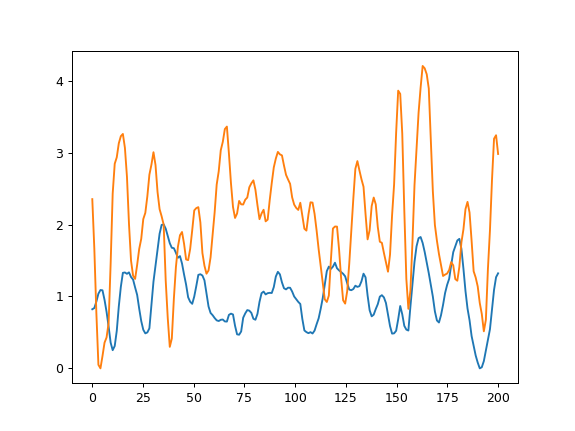

<IPython.core.display.Javascript object>


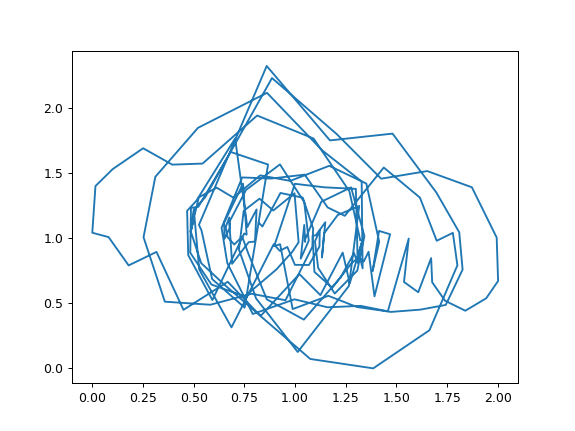

In [378]:
####
## Plot Mock
#
y0,y1,t = mock(200.0)

plt.figure()
plt.plot(t[0:],y0[0:,0])
plt.plot(t[0:],y1[0:,0])
plt.figure()
plt.plot(y0[:,0],y0[:,1])

In [9]:
####
##Retirar Sazonalidades por diferencas
#
ts = subtrai_sazonalidade(interpolated_ts.copy(),medianizar=15)

('numero de registros restantes: ', 1895)
('numero de registros retirados: ', 0)


('numero de registros restantes: ', 2001)
('numero de registros retirados: ', 0)


<IPython.core.display.Javascript object>


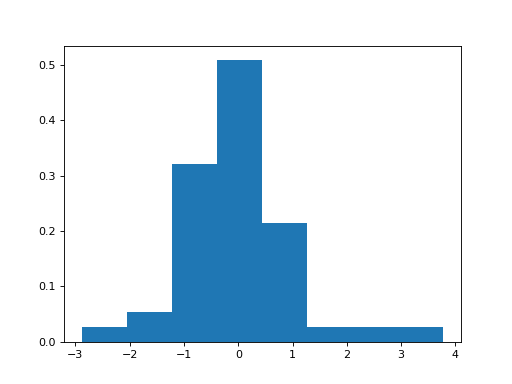

<IPython.core.display.Javascript object>


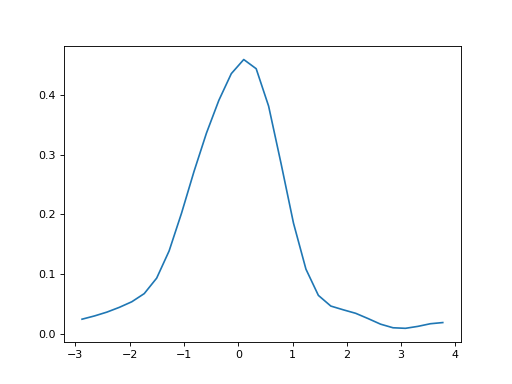

<IPython.core.display.Javascript object>


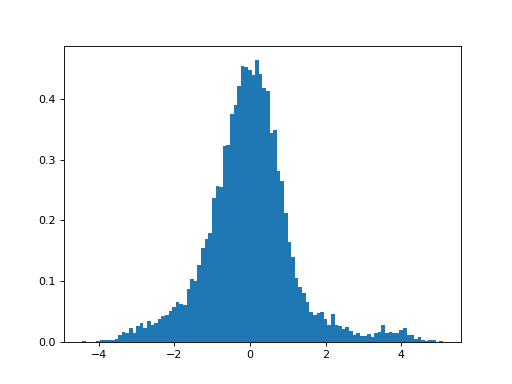

'\nInterpolar Kernel Gaussianos para estimar PDF e Resamplear gera pequenas gaussianas. Comparar com GEV.\n'

In [120]:
####
## Bootstrap
#

mresample,_ = to_tensor(hydrometer_ts,thresh=45)
x = np.mgrid[m0[5,:].min():m0[5,:].max():30j]
kernel = KernelDensity(kernel = "gaussian", bandwidth= 45**(-1.0/5.0) )
kernel.fit( m0[5,:].reshape(-1, 1) )
log_density = kernel.score_samples(x.reshape(-1, 1))
z = np.exp(log_density)

####
## Example
#

####
## Original Data
#
plt.figure()
plt.hist(m0[5,:], bins=8, density = True)

####
## Gaussian Kernel Interpolation Data PDF
#
plt.figure()
plt.plot(x,z)

####
## Gaussian Kernel Resampled Data Histogram
#
resampled = kernel.sample(n_samples = 10000)[:,0]
plt.figure()
plt.hist(resampled, bins=100, density = True)

####
## Notas
#
'''
Interpolar Kernel Gaussianos para estimar PDF e Resamplear gera pequenas gaussianas. Comparar com GEV.
'''


In [121]:
####
## Bootstrap Full Matrix
#

resampled = np.ndarray((mresample.shape[0], 10000))
for i in range(m0.shape[0]):
    
  kernel = KernelDensity(kernel = "gaussian", bandwidth=45**(-1.0/5.0))
  kernel.fit( m0[i, :].reshape(-1, 1) )
  resampled[i,:] = kernel.sample(n_samples = 10000)[:,0]

In [122]:
####
## Covariance and PCA
# Interpolated and Time-Series dict

m0,nomes0 = to_tensor(interpolated_ts,thresh=45)
m1,_ = to_tensor(hydrometer_ts,thresh=45)

mcov0 = np.cov(m0)
mcov1 = np.cov(m1)
mcov_resampled = np.cov(resampled)

eigv0 = np.linalg.eigvals(mcov0)
eigv1 = np.linalg.eigvals(mcov1)
eigv_resampled = np.linalg.eigvals(mcov_resampled)

print("Autovalores da covariancia 'PCA' para series interpoladas", np.int32(eigv0[0:80]))
print("Autovalores da covariancia 'PCA' para series", np.int32(eigv1[0:80]))
print("Autovalores da covariancia 'PCA' para series reamostrada", np.int32(eigv_resampled))
print("Numero de autovalores nao nulos para series interpoladas", len(np.nonzero(np.int32(eigv0[0:80]))[0]))
print("Numero de autovalores nao nulos para series interpoladas", len(np.nonzero(np.int32(eigv0[0:80]))[0]))
print("Numero de autovalores nao nulos para series reamostrada", len(np.nonzero(np.int32(eigv_resampled))[0]))

('numero de registros restantes: ', 452)
('numero de registros retirados: ', 0)
('numero de registros restantes: ', 2001)
('numero de registros retirados: ', 0)
("Autovalores da covariancia 'PCA' para series interpoladas", array([81, 38, 30, 23, 18, 16, 15, 13, 12, 10,  9,  8,  8,  8,  8,  7,  7,
        6,  6,  6,  6,  5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  3,  3,  3,
        3,  3,  3,  2,  2,  2,  2,  3,  2,  3,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32))
("Autovalores da covariancia 'PCA' para series", array([308, 158, 121,  90,  79,  76,  63,  60,  50,  46,  41,  40,  37,
        36,  35,  32,  31,  31,  30,  28,  28,  27,  27,  26,  25,  25,
        15,  24,  23,  23,  23,  22,  17,  21,  17,  18,  18,  21,  21,
        20,  20,  19,  19,  19,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0

/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


In [123]:
####
## Random Normal Data of (Mean,Std) of the sampled variable (hydrometer). For hypothesis of random normal time-series
#

random_dict = {}
for i in range(np.size(m0[i])):
  np.random.seed(i*i-i+127)
  random_dict[str(i)] = np.random.normal(m0[i].mean(),m0[i].std(),48)

IndexError: index 452 is out of bounds for axis 0 with size 452

In [42]:
####
## Covariance and PCA
# Null Hypothesis Time-Series

m_null,_ = to_tensor(random_dict,thresh=45)
mcov_null = np.cov(m_null)
eigv_null = np.linalg.eigvals(mcov_null)

print("Autovalores da covariancia 'PCA' Hipotese Nula", np.int32(eigv_null[0:80]))
print("Numero de autovalores nao nulos Hipotese Nula ", len(np.nonzero(np.int32(eigv_null[0:80]))[0]))

('numero de registros restantes: ', 1895)
('numero de registros retirados: ', 0)
("Autovalores da covariancia 'PCA' Hipotese Nula", array([55, 53, 52, 52, 51, 50, 50, 49, 48, 48, 47, 30, 46, 46, 31, 32, 32,
       33, 33, 33, 34, 34, 45, 45, 45, 44, 44, 36, 36, 37, 37, 38, 38, 43,
       43, 39, 42, 42, 42, 41, 40, 40, 40, 41,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32))
('Numero de autovalores nao nulos Hipotese Nula ', 44)


/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


## Visualizations
### Hydrometers, interpolated, sazonality subtracted versions
### Auto-correlation function for time-series
### Eigenvalue counting for covariance matrix in cases of time-series, interpolated ts and null-hypothesis ts.

<IPython.core.display.Javascript object>


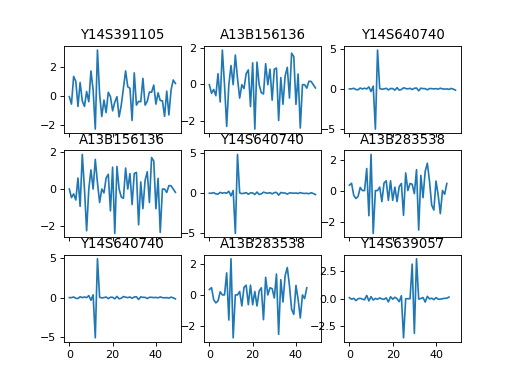

<IPython.core.display.Javascript object>


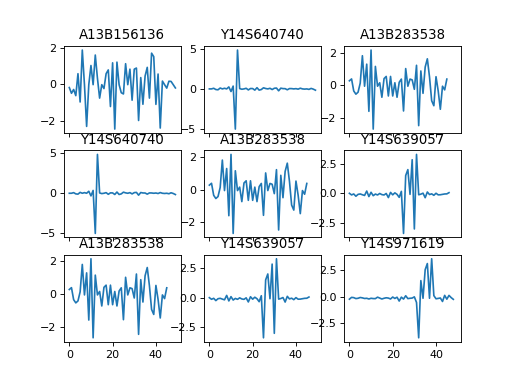

<IPython.core.display.Javascript object>


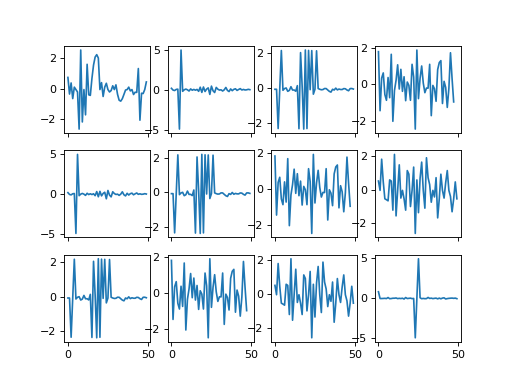

In [10]:
grid_plot(hydrometer_ts,(3,3))
grid_plot(interpolated_ts,(3,3))
grid_plot(ts,(3,4), hidronum=20)

('numero de registros restantes: ', 1895)
('numero de registros retirados: ', 0)


<IPython.core.display.Javascript object>


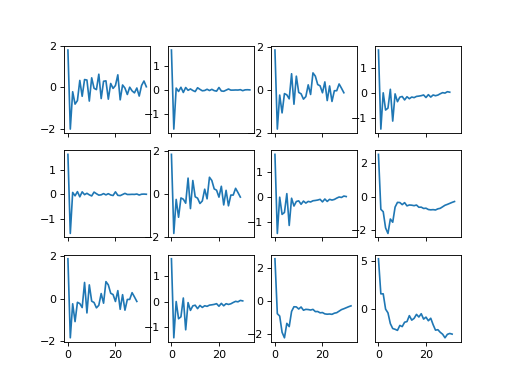

In [11]:
ac,_ = acf(interpolated_ts,15)
grid_plot(ac,(3,4), hidronum = 10)

[ -0.      6.906  13.81   20.72   27.62   34.53   41.44   48.34   55.25
  62.16   69.06   76.     82.9    89.8    96.7   103.6   110.5   117.44
 124.3   131.2  ]


/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


<IPython.core.display.Javascript object>


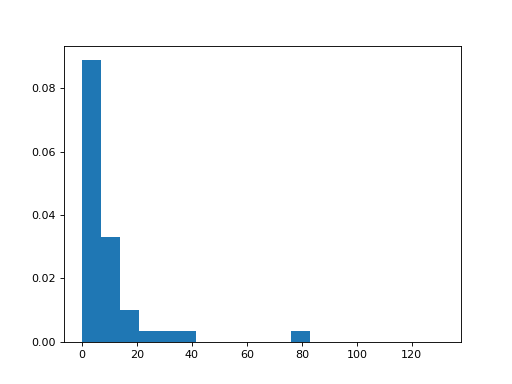

/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


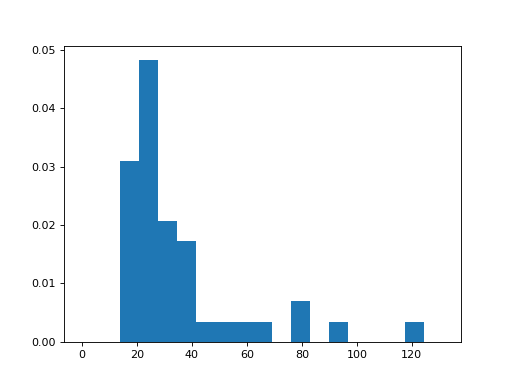

/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


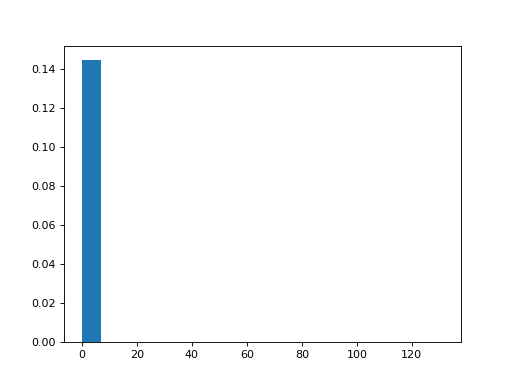

/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


<IPython.core.display.Javascript object>


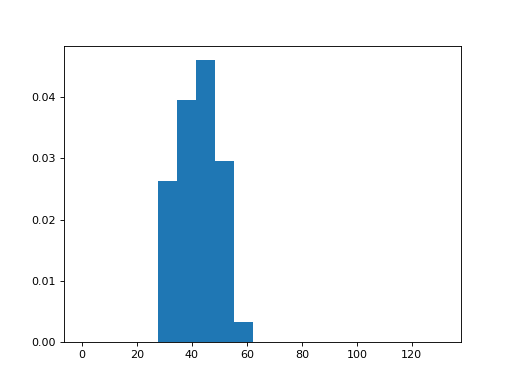

/home/stattus4dpenalva/.conda/envs/stats27/lib/python2.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


(array([0.        , 0.        , 0.        , 0.        , 0.02632661,
        0.03948992, 0.04607158, 0.02961744, 0.00329083, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ -0.   ,   6.906,  13.81 ,  20.72 ,  27.62 ,  34.53 ,  41.44 ,
         48.34 ,  55.25 ,  62.16 ,  69.06 ,  76.   ,  82.9  ,  89.8  ,
         96.7  , 103.6  , 110.5  , 117.44 , 124.3  , 131.2  ],
       dtype=float16),
 <a list of 19 Patch objects>)

In [126]:
####
## Plot histogram of eigenvals for covariance matrix of time series.
#

bins = np.linspace(np.sort(eigv0)[0],np.sort(eigv0)[-1]+50,20)
print(bins.astype(np.float16))

plt.figure()
plt.hist(eigv0[0:44],bins=bins.astype(np.float16), density = True)
plt.figure()
plt.hist(eigv1[0:44],bins=bins.astype(np.float16), density = True)
plt.figure()
plt.hist(eigv_resampled,bins=bins.astype(np.float16), density = True)
plt.figure()
plt.hist(eigv_null[0:44],bins=bins.astype(np.float16), density = True)

In [106]:
####
## Inverse Covariance
#

invcov0 = np.array([np.array([ 1.0/(mcov0[i,j]+1e-7) for j in range(np.size(mcov0[0,:]) ) ]) for i in range( np.size(mcov0[0,:]))])
invcov1 = np.array([np.array([ 1.0/(mcov1[i,j]+1e-7) for j in range(np.size(mcov1[0,:]) ) ]) for i in range( np.size(mcov1[0,:]))])
invcov_resampled = np.array([np.array([ 1.0/(mcov_resampled[i,j]+1e-7) for j in range(np.size(mcov_resampled[0,:]) ) ]) for i in range( np.size(mcov_resampled[0,:]))])
invcov2 = np.array([np.array([ 1.0/(mcov_null[i,j]+1e-7) for j in range(np.size(mcov_null[0,:]) ) ]) for i in range( np.size(mcov_null[0,:]))])

## Clustering Measures
### K-Means
### Agglomeration
### Mutual Information/TODO: Time Delayed Mutual Information

<IPython.core.display.Javascript object>


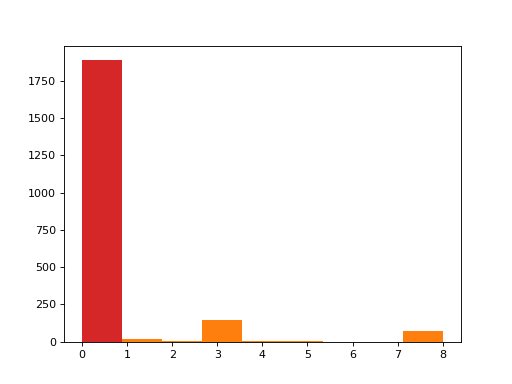

('Interp ', array([1.887e+03, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00]))
('Hydro ', array([1.755e+03, 2.000e+01, 4.000e+00, 1.440e+02, 2.000e+00, 3.000e+00,
       1.000e+00, 1.000e+00, 7.100e+01]))
('Null ', array([1.887e+03, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00]))
('Resampled ', array([1.887e+03, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00]))


In [107]:
####
## Clustering
#

# KMeans
plt.figure()
kclassifier = KMeans(n_clusters = 9, n_init = 40, random_state = 137)
y = kclassifier.fit(invcov0).predict(invcov0)
countm0,_,_ = plt.hist(y,bins=9)

kclassifier = KMeans(n_clusters = 9, n_init = 30, random_state = 451)
y = kclassifier.fit(invcov1).predict(invcov1)
countm1,_,_ = plt.hist(y,bins=9)

kclassifier = KMeans(n_clusters = 9, n_init = 17, random_state = 1337)
y = kclassifier.fit(invcov2).predict(invcov2)
countm2,_,_ = plt.hist(y,bins=9)

kclassifier = KMeans(n_clusters = 9, n_init = 70, random_state = 337)
y = kclassifier.fit(invcov_resampled).predict(invcov_resampled)
countm3,_,_ = plt.hist(y,bins=9)

print('Interp ',countm0)
print('Hydro ',countm1)
print('Null ',countm2)
print('Resampled ',countm3)

<IPython.core.display.Javascript object>


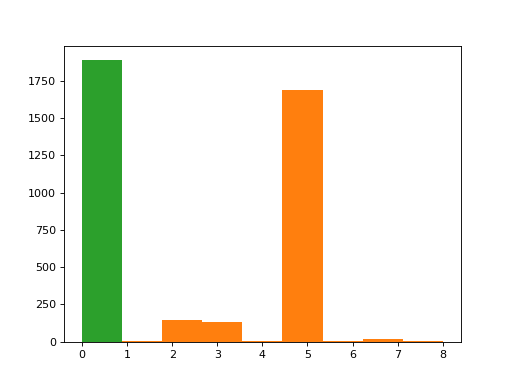

('Interp ', array([1.887e+03, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00]))
('Hydro ', array([   3.,    2.,  144.,  135.,    3., 1689.,    3.,   20.,    2.]))
('Null ', array([1.887e+03, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00]))


In [16]:
####
## Clustering
#

# Agglomeration
plt.figure()
aggclassifier = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
y = aggclassifier.fit_predict(invcov0)
countm0,_,_ = plt.hist(y,bins=9)

aggclassifier = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
y = aggclassifier.fit_predict(invcov1)
countm1,_,_ = plt.hist(y,bins=9)

aggclassifier = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
y = aggclassifier.fit_predict(invcov2)
countm2,_,_ = plt.hist(y,bins=9)


print('Interp ',countm0)
print('Hydro ',countm1)
print('Null ',countm2)